# Training11

In this notebook file, ThirdQuarter-FullPhoto dataset will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

VGG16 pre-trained model will be load and used.

Pre-trained model's layers except the last CNN block will be set to non-trainable

Training will be performed in the sections between the last CNN block and the Output layer

In this way, the experience gained by the model on very large datasets will be used in this classification problem, while the last CNN block will be updated and fine-tuned.

This method is known as [**Fine-Tuning**](https://deeplizard.com/learn/video/5T-iXNNiwIs "deeplizard").

See also [**Transfer Learning and Fine-Tuning**](https://www.tensorflow.org/tutorials/images/transfer_learning "tensorflow").

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#Person dataframe in ThirdQuarter is being read from pkl file
personDf = pd.read_pickle("../../../Data/ThirdQuarter/Person.pkl")
personDf

,Name
ID,
0,Adrien Brody
1,Anna Kournikova
2,Ann Veneman
3,Ari Fleischer
4,Bill McBride
5,Catherine Zeta-Jones
6,Charles Moose
7,Condoleezza Rice
8,Edmund Stoiber


In [5]:
#FullPhoto Training data is being read from pkl file
trainingDf = pd.read_pickle("../../../Data/ThirdQuarter/FullPhoto/Training.pkl")
trainingDf

,PersonID,ImageBGR
0,1,"[[[42, 19, 17], [42, 19, 17], [42, 19, 17], [4..."
1,18,"[[[0, 0, 3], [0, 0, 3], [0, 0, 3], [0, 0, 3], ..."
2,38,"[[[79, 81, 89], [78, 81, 89], [78, 80, 88], [7..."
3,50,"[[[31, 37, 36], [36, 44, 43], [39, 50, 50], [3..."
4,48,"[[[89, 124, 150], [87, 122, 148], [84, 119, 14..."
...,...,...
407,41,"[[[52, 78, 108], [53, 79, 109], [56, 80, 109],..."
408,3,"[[[227, 242, 238], [240, 253, 247], [247, 254,..."
409,34,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
410,14,"[[[21, 39, 38], [24, 42, 41], [27, 45, 46], [2..."


In [6]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Data augmentation, can be done in Data Preparation process or this section to save time
#But this method is not preferred due to memory problems

trainingX = (np.array(trainingDf.ImageBGR.values.tolist()) / 127.5) - 1
trainingX.shape

(412, 224, 224, 3)

In [7]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.PersonID.values.tolist()).reshape((-1,1))
trainingY.shape

(412, 1)

In [8]:
#FullPhoto Validation data is being read from pkl file
validationDf = pd.read_pickle("../../../Data/ThirdQuarter/FullPhoto/Validation.pkl")
validationDf

,PersonID,ImageBGR
0,32,"[[[62, 98, 86], [62, 98, 86], [62, 98, 86], [6..."
1,13,"[[[37, 11, 7], [37, 11, 7], [37, 11, 7], [37, ..."
2,20,"[[[4, 2, 2], [3, 1, 1], [1, 0, 0], [0, 0, 0], ..."
3,36,"[[[94, 42, 6], [89, 40, 4], [80, 35, 2], [70, ..."
4,41,"[[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], ..."
...,...,...
91,28,"[[[0, 2, 0], [0, 1, 0], [2, 1, 0], [4, 1, 0], ..."
92,6,"[[[48, 84, 68], [47, 83, 67], [47, 82, 68], [4..."
93,9,"[[[22, 27, 36], [20, 24, 33], [17, 22, 31], [1..."
94,39,"[[[0, 1, 1], [0, 0, 0], [1, 1, 1], [0, 1, 0], ..."


In [9]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

validationX = (np.array(validationDf.ImageBGR.values.tolist()) / 127.5) - 1
validationX.shape

(96, 224, 224, 3)

In [10]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.PersonID.values.tolist()).reshape((-1,1))
validationY.shape

(96, 1)

In [11]:
#VGG16 pre-trained model is being loaded
#The original VGG16 model was trained with images with size of (224, 224, 3) 
#in BGR color order and pixel values of [-1, 1] (zero centered) as default
#See https://keras.io/api/applications/vgg/ for more information
#Since images of dataset saved as size of (224, 224, 3) in BGR color order and pixel values of [0, 255]
#Pixel values were converted to [-1, 1] range while preparing trainingX and validationX

#Training will be performed in the sections between the last CNN block and the Output layer

model = tf.keras.applications.vgg16.VGG16(include_top = False, input_shape = ((224, 224, 3)))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
#Number of layers of pre-trained model is being calculated except last CNN block
nonTrainablePart = len(model.layers) - 4
nonTrainablePart

15

In [13]:
#Pre-trained model's layers except the last CNN block is being set to non-trainable
for layer in model.layers[:nonTrainablePart]:
    layer.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
#The pre-trained model is being connected to the fully connected layer where the training will performed
#A dropout layer is being added to the the model to prevent overfitting,
#and the model is being completed with the addition of the output layer
model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(personDf.shape[0], activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 52)                106548    
Total params: 70,399,860
Trainable params: 62,764,596
Non-trainable params: 7,635,264
____________________________________

In [15]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [16]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize, imagesPerImage):
        self.image, self.label = image, label
        self.batchSize = batchSize
        
        #A numpy array for image indexes is being created
        #This array will be used to shuffle the data
        self.index = np.arange(self.image.shape[0])
        self.imagesPerImage = imagesPerImage
        
        #batch sizes are being calculated for correct information during training
        self.originalBatch = self.image.shape[0] / float(self.batchSize)
        self.batchLen = int(np.ceil(self.originalBatch * self.imagesPerImage))
        self.originalBatch = int(np.ceil(self.originalBatch))
        self.repeatData = -1
        
        #Image Augmentation layer
        #See https://www.tensorflow.org/tutorials/images/data_augmentation
        self.imageAugmentation = tf.keras.Sequential([
          tf.keras.layers.RandomFlip("horizontal_and_vertical"),
          tf.keras.layers.RandomRotation(0.2),
        ])
        

    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return self.batchLen

    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #Since randomly augmented images obtained from the same image will be added to the batches,
        #there will be more batches than expected
        #so the taken index is updated by taking the mode according to the original batch
        idx = idx % self.originalBatch
        
        #If the index is 0, that is, the loop in the epoch has returned to the beginning
        if idx == 0:
            
            #The index array is being shuffled
            #so that the data in the next repeat is returned in different orders
            np.random.shuffle(self.index)
            
            #repeatData is being incremented by 1
            self.repeatData += 1
            
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        #if it is the first iteration of data in the epoch,
        #selected data from data in original list are being returned
        if self.repeatData == 0:
            return self.__OriginalBatch(indexPart)
        
        #if it is not the first iteration of data in the epoch,
        #data augmented using select data are being returned
        else:
            return self.__AugmentedBatch(indexPart)
        
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #repeatData is updated to -1 at the end of each epoch
        self.repeatData = -1
    
    #this method will be called if element from original list will be returned
    def __OriginalBatch(self, indexPart):
        
        batchX = self.image[indexPart]
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #This method will be called if images created with the data augmentation method will be returned
    #Doing Data Augmentation operation here means that it will be repeated as many epochs for each image and this wastes time
    #On the other hand, since the data augmentation process is done with random rotation and random flip,
    #different variations can be obtained of the original image each time
    #This can be have a preventative effect on overfitting
    def __AugmentedBatch(self, indexPart):
        augmentedList = []
        for i in indexPart:
            augmentedList.append(self.imageAugmentation(self.image[i]))
        
        batchX = np.array(augmentedList)
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)

In [17]:
#model is being trained with 50 epochs and 16 batchSize using GPU
#A small batchSize value is being chosen to prevent GPU memory problem
#Large batchSize reduce training time while also generally providing better results

#3 more images will be obtained from each original for training data so the number of images will be quadrupled
#Only the originals of the validation data will be used

with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, 16, 4),
        epochs = 50,
        validation_data = FitSequence(validationX, validationY, 16, 1)
    )

Epoch 1/50
103/103 [==============================] - 117s 987ms/step - loss: 4.3372 - accuracy: 0.0171 - val_loss: 3.9486 - val_accuracy: 0.0104
Epoch 2/50
103/103 [==============================] - 79s 766ms/step - loss: 3.9515 - accuracy: 0.0226 - val_loss: 3.9478 - val_accuracy: 0.0104
Epoch 3/50
103/103 [==============================] - 95s 920ms/step - loss: 3.9502 - accuracy: 0.0226 - val_loss: 3.9457 - val_accuracy: 0.0104
Epoch 4/50
103/103 [==============================] - 98s 949ms/step - loss: 3.9507 - accuracy: 0.0220 - val_loss: 3.9472 - val_accuracy: 0.0104
Epoch 5/50
103/103 [==============================] - 99s 957ms/step - loss: 3.9491 - accuracy: 0.0251 - val_loss: 3.9471 - val_accuracy: 0.0104
Epoch 6/50
103/103 [==============================] - 84s 813ms/step - loss: 3.9492 - accuracy: 0.0226 - val_loss: 3.9457 - val_accuracy: 0.0104
Epoch 7/50
103/103 [==============================] - 94s 915ms/step - loss: 3.9491 - accuracy: 0.0238 - val_loss: 3.9442 - val_a

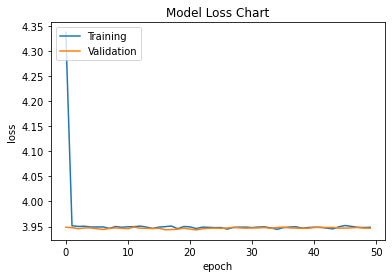

In [18]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

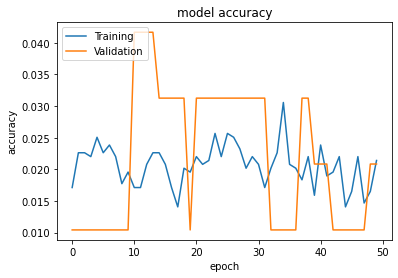

In [19]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [20]:
#FullPhoto Test data is being read from pkl file
testDf = pd.read_pickle("../../../Data/ThirdQuarter/FullPhoto/Test.pkl")
testDf

,PersonID,ImageBGR
0,7,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,19,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,50,"[[[15, 13, 13], [15, 13, 13], [14, 12, 12], [1..."
4,9,"[[[44, 77, 63], [44, 77, 63], [44, 77, 63], [4..."
...,...,...
76,27,"[[[0, 1, 0], [1, 2, 0], [1, 2, 0], [3, 1, 0], ..."
77,29,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
78,33,"[[[15, 7, 8], [15, 7, 8], [15, 6, 8], [15, 4, ..."
79,35,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."


In [21]:
#testX is being extracted from testDf as wanted shape
#Pixel values are being converted  to the [-1, 1] range with the simplest method (pixel / 127.5 - 1)
testX = (np.array(testDf.ImageBGR.values.tolist()) / 127.5) - 1
testX.shape

(81, 224, 224, 3)

In [22]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.PersonID.values.tolist()).reshape((-1,1))
testY.shape

(81, 1)

In [23]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, 16, 1))

6/6 [==============================] - 5s 807ms/step - loss: 3.9470 - accuracy: 0.0247


In [24]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 3.946950674057007


In [25]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.02469135820865631


# Training11 Inference

By looking at the charts, it can be seen that learning does not take place.

The model has not learned enough to have any success even on the Training data, even overfitting did not occur.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.